# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [83]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

import matplotlib.pyplot as plt
import seaborn as sns

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [84]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [85]:
sums = [data.loc[i].sum() for i in range(440)]
print(np.argmin(sums))
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [29, 154, 155]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

154
Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,43088,2100,2609,1200,1107,823
1,622,55,137,75,7,8
2,1989,10690,19460,233,11577,2153


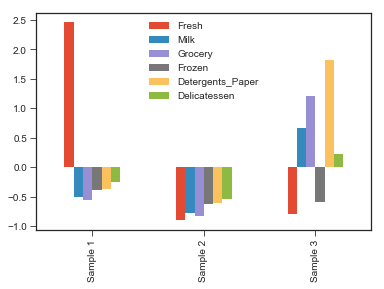

In [86]:
samples_for_plot = samples.copy()
samples_for_plot = (samples_for_plot - data.mean())/data.std()

labels = ['Sample 1','Sample 2','Sample 3']
samples_for_plot.plot(kind='bar')
_ = plt.xticks(range(3),labels)

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 3071.9
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

**0.** This looks like it might be a deli since deli's main products are fresh breads, meats, and vegtables.

**1.** This is probably a small local single owner deli or cafe.

**2.** This looks more like a wholesale retailer.  Lots of non-perishables (i.e. Grocery, Detergents, and Paper)

The samples are obviously very different in the amounts of different types of goods.  From the mean values we get a strong indication that there are a lot of cafe/deli type businesses.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
feature_name = 'Grocery'
fresh_raw = data[feature_name]
new_data = data.drop(feature_name, axis=1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    fresh_raw, 
                                                    test_size=0.25, 
                                                    random_state=10)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=10)
regressor = regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
print(regressor.score(X_test, y_test))

0.723800832652


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

def calculate_r_2_for_feature(data, feature):
    new_data = data.drop(feature, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(new_data,
                                                        data[feature],
                                                        test_size=0.25)

    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)

    return regressor.score(X_test, y_test)

def r_2_mean(data, feature, runs=200):
    return np.array([calculate_r_2_for_feature(data, feature) for _ in range(runs)]).mean().round(4)

print("{0:18} {1:>7.4f}".format("Fresh: ", r_2_mean(data,'Fresh')))
print("{0:18} {1:>7.4f}".format("Milk: ", r_2_mean(data,'Milk')))
print("{0:18} {1:>7.4f}".format("Grocery: ", r_2_mean(data,'Grocery')))
print("{0:18} {1:>7.4f}".format("Frozen: ", r_2_mean(data,'Frozen')))
print("{0:18} {1:>7.4f}".format("Detergents_Paper: ", r_2_mean(data,'Detergents_Paper')))
print("{0:18} {1:>7.4f}".format("Delicatessen: ", r_2_mean(data,'Delicatessen')))

Fresh:             -0.7969
Milk:               0.1391
Grocery:            0.6782
Frozen:            -1.1414
Detergents_Paper:   0.6716
Delicatessen:      -2.6377


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that leads us to believe that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

I attempted to predict `Detergents_Paper`. The predicted score was 69.12%.  Since it seems that this feature is easy to predict using the other features, I would say, that it is not that important of a feature to consider.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

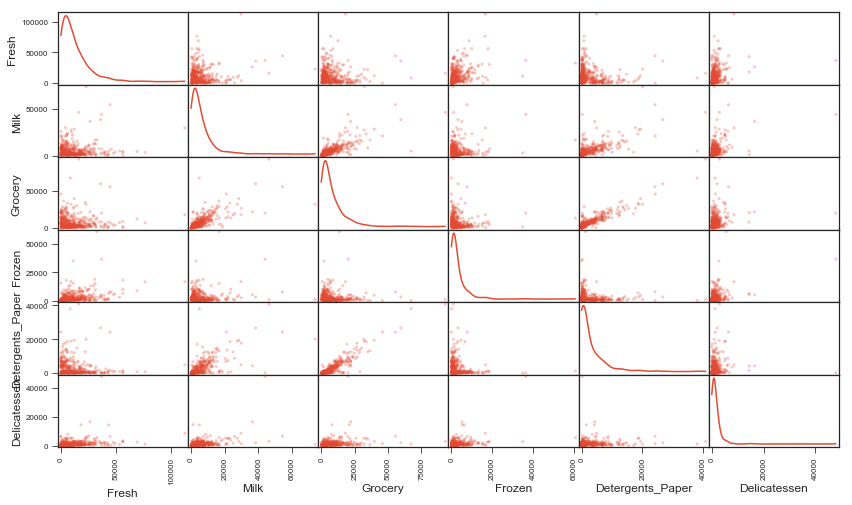

In [89]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

**Answer:**

According to the scatter matrix, `Milk` vs `Grocery`, `Grocery` vs `Detergents_Paper`, and `Detergents_Paper` vs `Milk` all seem to be highly correlated.  This confirms my suspicions about `Detergents_Paper` being highly correlated.  Also, the heatmap verifies my predictions.  (Thanks for suggesting seaborn, another nice tool to have in my toolpouch.

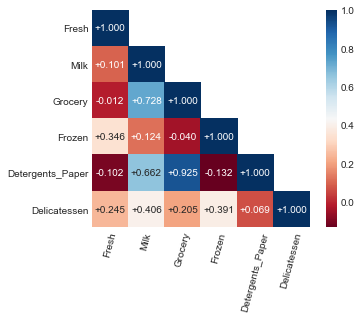

In [90]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.3f')
    plt.xticks(rotation=75, ha='center')

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

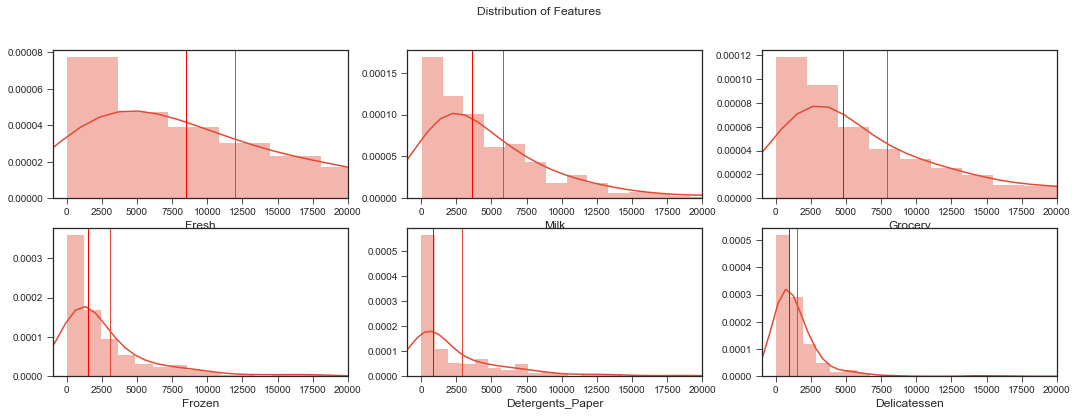

In [91]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
fig.set_size_inches(18, 6)
fig.suptitle('Distribution of Features')

for i, col in enumerate(data.columns):
    feature = data[col]
    sns.distplot(feature, label=col, ax=axes[i]).set(xlim=(-1000, 20000),)
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')

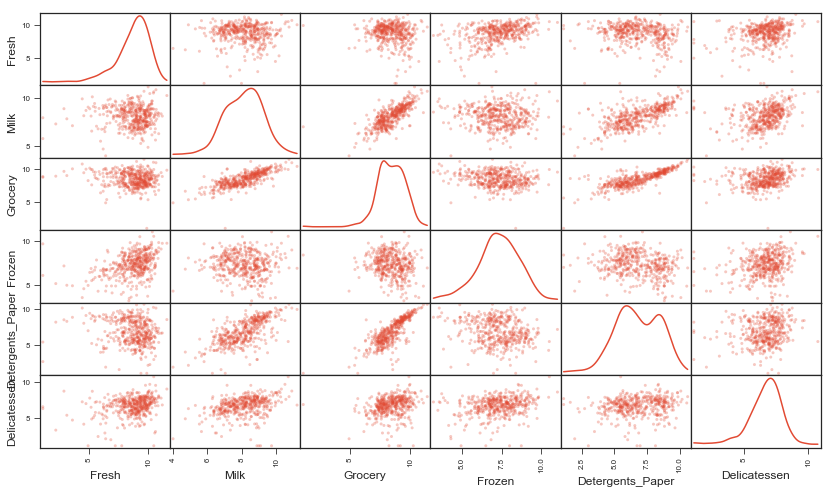

In [92]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

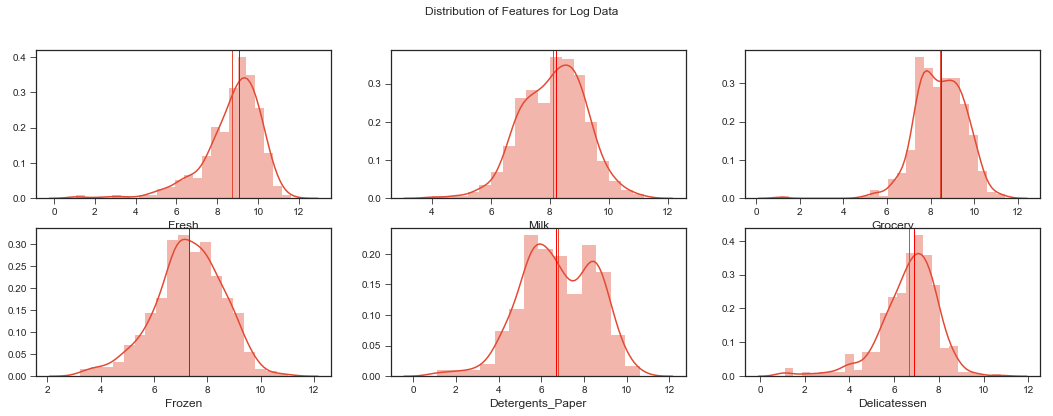

In [93]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
fig.set_size_inches(18, 6)
fig.suptitle('Distribution of Features for Log Data')

for i, col in enumerate(log_data.columns):
    feature = log_data[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')

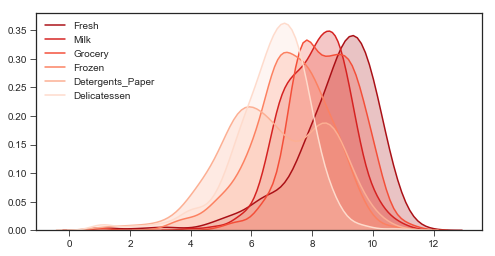

In [94]:
# set plot style & color scheme
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    # plot densities of log data
    plt.figure(figsize=(8,4))
    for col in data.columns:
        sns.kdeplot(log_data[col], shade=True)
    plt.legend(loc='best')

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [95]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.671000,7.649693,7.866722,7.090077,7.009409,6.712956
1,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
2,7.595387,9.277064,9.876116,5.451038,9.356776,7.674617


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [96]:
log_data_stats = log_data.describe()
display(log_data_stats)
print(log_data_stats.get_values()[4])
print(log_data_stats.get_values()[6])
log_data_stats.Detergents_Paper[4]
log_data_stats.keys()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


[ 8.0480587   7.33498124  7.6746162   6.60967775  5.54810142  6.01187466]
[ 9.73706395  8.88048009  9.27385368  8.17589608  8.2743406   7.50672843]


Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicatessen'],
      dtype='object')

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(log_data)

log_data = scaler.transform(log_data)
log_samples = scaler.transform(log_samples)

log_data = pd.DataFrame(scaler.transform(log_data), columns = data.keys())

In [97]:
import operator

def highlight_outliers(data, iqr_type='min', iqr_color='lightyellow', iqr_thresh=100):
    '''
    highlight the outliers in a Series yellow.
    '''    
    attr_color = 'background-color: {}'.format(iqr_color)
    is_outlier = data < iqr_thresh if iqr_type == 'min' else data > iqr_thresh
    return [attr_color if v else '' for v in is_outlier]

correlated_features = ['Milk', 'Grocery', 'Detergents_Paper']

# TODO: Calculate Q1 (25th percentile of the data) for the given feature
Q1 = log_data_stats.get_values()[4]
# TODO: Calculate Q3 (75th percentile of the data) for the given feature
Q3 = log_data_stats.get_values()[6]
# TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
step = (Q3 - Q1) * 1.5

iqr_min = Q1 - step
iqr_max = Q3 + step

feature_outlier_indices = {}
for i, feature in enumerate(log_data.keys()):
    feature_outlier = log_data[~((log_data[feature] >= iqr_min[i]) & (log_data[feature] <= iqr_max[i]))]
    feature_outlier_indices[feature] = feature_outlier.index
    
# For each feature find the data points with extreme high or low values
# for i, feature in enumerate(log_data.keys()):
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
#     Q1 = log_data_stats[feature][4]
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
#     Q3 = log_data_stats[feature][6]
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
#     step = (Q3 - Q1) * 1.5
#     feature_outlier = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    # Display the outliers
#     print("Data points considered outliers for the feature '{}':".format(feature))
#     print(feature_outlier)

# OPTIONAL: Select the indices for data points you wish to remove

outlier_counts = {i: 0 for i in range(440)}
for feature in log_data.keys():
    for idx in feature_outlier_indices[feature]:
        outlier_counts[idx] += 1
    
print('Outlier Tallys')
outlier_groups = {i: [] for i in range(7)}
for key, value in outlier_counts.items():
    outlier_groups[value].append(key)        
for key, values in outlier_groups.items():
    print(key, len(values))
    
outlier_multifeatures = {}
for i in range(440):
    multifeature = []
    outlier_found = False
    for feature, outlier_indices in feature_outlier_indices.items():
        if i in outlier_indices:
            feat = feature
            outlier_found = True
        else:
            feat = '_'*len(feature)
        multifeature.append('{}'.format(feat))
            
    if outlier_found:
        outlier_multifeatures.setdefault(tuple(multifeature), []).append(i)

print('\nMultiple Feature Outliers')
unique_outliers_indices = []
for key, value in sorted(outlier_multifeatures.items(), key=lambda value: len(value[1]), reverse=True):
    unique_outliers_indices += value
    print(''.join(key), value)
        
unique_outliers_indices = pd.Index(sorted(tuple(unique_outliers_indices)))
unique_outliers = pd.DataFrame(log_data.loc[unique_outliers_indices], columns=log_data.keys())
s = unique_outliers.style.apply(
    highlight_outliers, iqr_type='min', iqr_color='lightyellow', iqr_thresh=iqr_min, axis=1).apply(highlight_outliers, iqr_type='max', iqr_color='lightblue', iqr_thresh=iqr_max, axis=1)
display(s)

# Drop this highly correlated datapoint from the outliers.
outliers = unique_outliers_indices.drop([154])

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop=True)

Outlier Tallys
0 398
1 37
2 4
3 1
4 0
5 0
6 0

Multiple Feature Outliers
Fresh_____________________________________________ [81, 95, 96, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412]
______________________________________Delicatessen [109, 137, 142, 183, 184, 187, 203, 233, 285, 289, 343]
________________Frozen____________________________ [38, 57, 145, 175, 264, 325, 420, 429, 439]
_____Milk_________________________________________ [86, 98, 356]
Fresh_________________________________Delicatessen [66, 128]
Fresh___________Frozen____________________________ [65]
_________Grocery______Detergents_Paper____________ [75]
_____MilkGrocery______________________Delicatessen [154]
______________________Detergents_Paper____________ [161]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.43185,9.66326,9.7237,3.49651,8.84736,6.07074
57,8.5973,9.20362,9.25789,3.63759,8.93221,7.15618
65,4.44265,9.95032,10.7327,3.58352,10.0954,7.26052
66,2.19722,7.33563,8.91153,5.16479,8.15133,3.29584
75,9.92319,7.03615,1.09861,8.39095,1.09861,6.88244
81,5.38907,9.16325,9.57519,5.64545,8.96418,5.04986
86,10.04,11.205,10.377,6.89467,9.90698,6.80572
95,1.09861,7.97934,8.74066,6.08677,5.40717,6.56386
96,3.13549,7.8694,9.00184,4.97673,8.26204,5.3799
98,6.22059,4.7185,6.65673,6.79682,4.02535,4.8828


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

There are just 5 datapoints that are outliers in multiple categories. 4 datapoints are outliers in 2 categories, and 1 datapoint (No. 154) is an outlier in 3 categories.

At this point, since I only know that `Milk`, `Grocery`, and `Detergents_Paper` are highly correlated, then I know that a datapoint with all three on the low end **or** all three on the high end means it's probably **not** an outlier.  This means that datapoint No. 154 (which is in my original sample set), will not be included as an outlier for this project as it has all three values on the low end of the scale.

In an attempt to be more pythonic, I vectorized out the calculation of `Q1`, `Q3`, and `step` above. Haven't quite figured out how to vectorize the rest of the for loop, but that's for another day.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

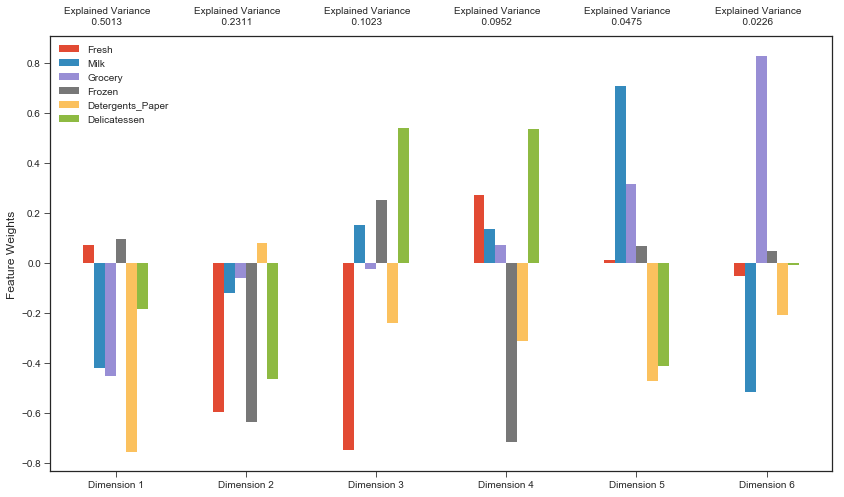

In [98]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

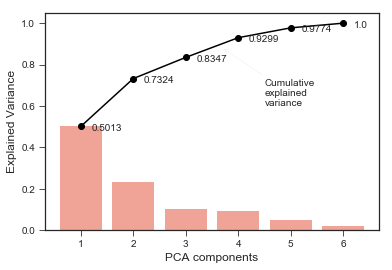

In [99]:
# create an x-axis variable for each pca component
x = np.arange(1,7)

# plot the cumulative variance
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o', color='black')

# plot the components' variance
plt.bar(x, pca.explained_variance_ratio_, align='center', alpha=0.5)

# plot styling
plt.ylim(0, 1.05)
plt.annotate('Cumulative\nexplained\nvariance',
             xy=(3.7, .88), arrowprops=dict(arrowstyle='->'), xytext=(4.5, .6))
for i, j in zip(x, np.cumsum(pca.explained_variance_ratio_)):
    plt.annotate(str(j.round(4)), xy=(i+.2, j-.02))
plt.xticks(range(1, 7))
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.show()

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

**Answer:**

The total explained variance by the first and second principal components is 0.7308, for the first 4 principal components it is 0.9168.  Looking at the visualization, one can see that `Milk`, `Grocery`, and `Detergents_Paper` have high variance along `Dimension 1` while `Fresh`, `Frozen`, and `Delicatessen` have high variance along `Dimension 2`.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [100]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,0.3692,-0.6862,-1.5462,0.4985,-0.5802,-0.3685
1,7.3391,5.9738,-0.8380,-0.2586,-0.0223,0.2534
2,-3.5517,1.6102,0.5035,0.9770,-0.4426,0.0440


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [110]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [102]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,0.3692,-0.6862
1,7.3391,5.9738
2,-3.5517,1.6102


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

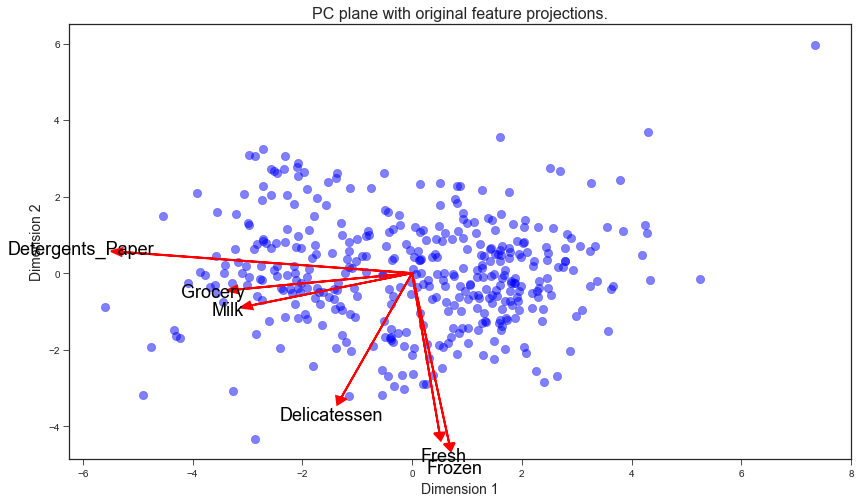

In [103]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

The advantages of KMeans clustering is that you have a way to group (or cluster) data together with no prior knowledge of what the group labels are.  This algorithm is also very easy to implement by hand and very fast in practice.

Gaussian Mixture Models assume the data was generated from some normal (or Gaussian) distribution.  In this way, the model is able to better represent the clusters using the centers of the Gaussian distribution and the covariances associated with the data.

Since GMM's tend to diverge in data-hungry environments, my guess is that KMeans is the correct choice here.  The question is, "How much data must you lack to be considered 'hungry'?"  I guess it depends on how many feature dimensions you have in your data.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [104]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=2).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print(score)

0.443892361616


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

* 2, 0.444
* 3, 0.360
* 4, 0.329
* 5, 0.343
* 6, 0.360
* 7, 0.365
* 8, 0.340
* 9, 0.366

The best score is when $k = 2$. This makes sense since the data distributes itself rather well across only 2 dimensions.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

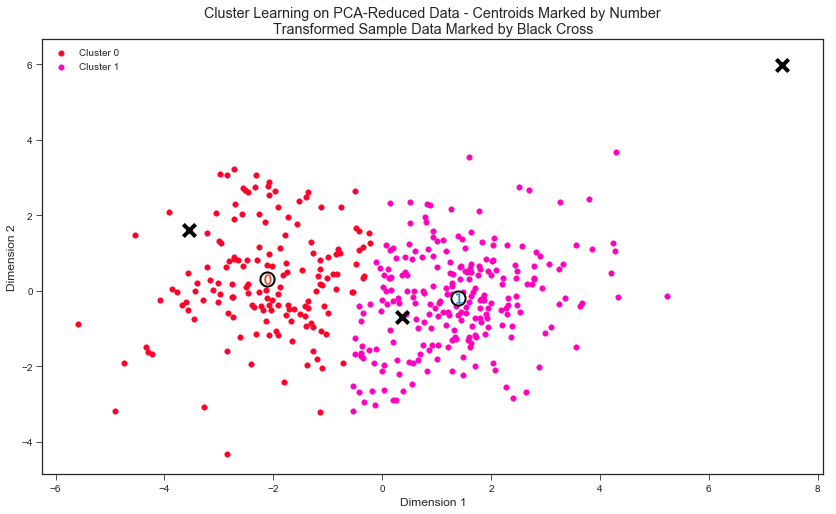

In [105]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [114]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
# true_centers = scaler.inverse_transform(log_centers)
# print(true_centers)
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,5406.0,7792.0,11519.0,1123.0,4437.0,1139.0
Segment 1,9365.0,1908.0,2422.0,2169.0,302.0,755.0


([<matplotlib.axis.XTick at 0x7fae41b61240>,
 <a list of 4 Text xticklabel objects>)

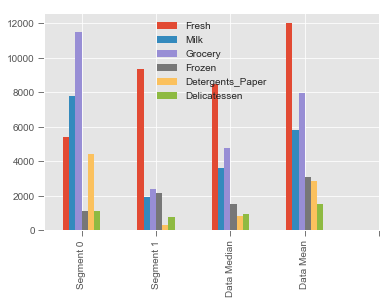

In [111]:
true_centers_copy = true_centers.copy()
true_centers_copy.loc[true_centers_copy.shape[0]] = data.median()
true_centers_copy.loc[true_centers_copy.shape[0]] = data.mean()

plt.style.use('ggplot')
true_centers_copy.plot(kind='bar')
labels = true_centers.index.values.tolist()
labels.append("Data Median")
labels.append("Data Mean")
plt.xticks(range(true_centers_copy.shape[0]+1),labels)

### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

A customer who is assigned to `Cluster 0` should best identify with the establishments represented by the feature set of `Segment 1`, namely retail and supermarkets. 

A customer who is assigned to `Cluster 1` should best identify with the establishments represented by the feature set of `Segment 0`, namely cafes and resturants. 

**Note:** The first grader marked this question as a redo, but gave no indication what was wrong.  Regardless, I still believe it is correct so I'm leaving it as-is. 

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [112]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

Segment 1 best represents Sample point 0 and 1, while Segment 0 best represents Sample point 2.  Yes the predictions are consistent.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

Going from 5 days a week to 3 days a week means longer durations between deliveries.  This will force the customers to pay better attention to and better approximate what and how much of what they order.  Items in the `Detergents_Paper` category tend to last a very long time (years). Items in the `Frozen` category can probably last at least 4 weeks and most likely up to 6 months.  I think it is safe to assume that `Grocery` items are things that do not need refrigeration (otherwise why have separate categories for `Fresh`, `Milk`, and `Frozen`), so dry perishable goods (e.g. cereal, crackers, bread, etc.) and vacuum sealed goods (e.g. canned soups, condiments, a case of Mt. Dew, etc.) would fall in this category. The shelf life of these goods is typically on the order of a few weeks (for perishables) to a year or so (for sealed goods).  `Milk` and other dairy products usually have about a 2 week shelf life.  Changing the delivery service from 5 to 3 days a week will most likely not have any significant impact on customers who rely primarily on these 4 item categories.  However, items in the last 2 categories . Customers who consume many items in the `Fresh` and `Delicatessen` categories, both of which tend to have a shelf life of 1 to 3 days are most likely to be adversely affected by the change.

The majority of companies that are highly correlated to both the `Fresh` and `Delicatessen` categories belong to `Segment 0`.  They will be negatively affected by the change.  Companies that are highly correlated to the `Detergents_Paper` and `Grocery` categories belong to `Segment 1`.  These companies will most likely react positively to the change.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

If you make the engineered feature the target label (or target variable) then train the network on the original customers, you should be able to and predict the target variable for new customers based on the new customers anticipated annual spending.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

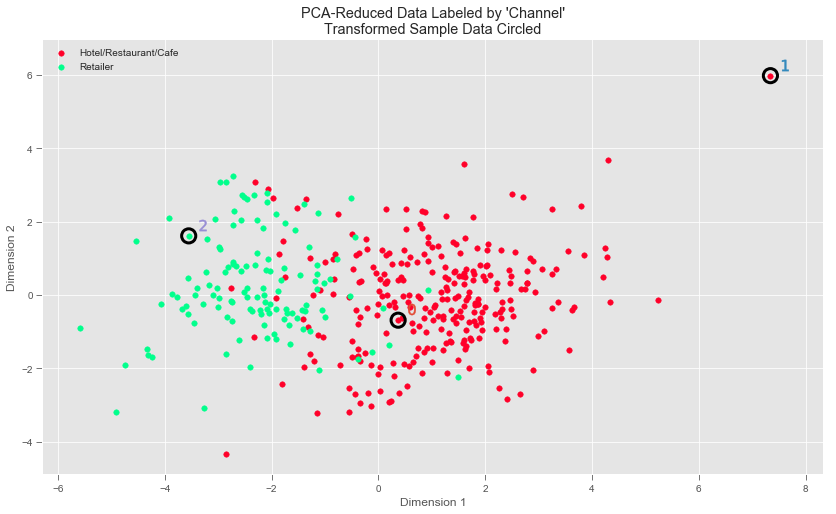

In [113]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

* I'd say it agrees quite nicely. There is clearly the same level of separation between my 2 original clusters and the `HoReCa/Retail` clusters shown here.  

* Yes. Data points less than -3 along `Dimension 1` are purely `Retail` and data points greater than about 1.5 along `Dimension 1` are purely `HoReCa`.

* Sample points 0 and 1 belong to `Cluster 0` which is commensurate with the `HoReCa` cluster, while `Cluster 1` which contains Sample point 2, is commensurate with the `Retail` cluster.  Yes the predictions are consistent.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.